In [1]:
import pandas as pd
import numpy as np
from numpy import log
from matplotlib import pyplot as plt 
from scipy.integrate import odeint  # 微分用

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest

import warnings
warnings.filterwarnings("ignore")

In [9]:
import os
import sys

# 確保項目根目錄在模組路徑中
project_root = os.path.abspath("COVID-19-TIME-SERIES-PREDICT")  # 替換為你的根目錄路徑
if project_root not in sys.path:
    sys.path.append(project_root)

# 導入自編模組
from utils.common_tools import *

In [10]:
data = read_covid_data()  # -> pd.DataFrame
data.head()

['AFG' 'OWID_AFR' 'ALB' 'DZA' 'AND' 'AGO' 'AIA' 'ATG' 'ARG' 'ARM' 'ABW'
 'OWID_ASI' 'AUS' 'AUT' 'AZE' 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ'
 'BEN' 'BMU' 'BTN' 'BOL' 'BES' 'BIH' 'BWA' 'BRA' 'VGB' 'BRN' 'BGR' 'BFA'
 'BDI' 'KHM' 'CMR' 'CAN' 'CPV' 'CYM' 'CAF' 'TCD' 'CHL' 'CHN' 'COL' 'COM'
 'COG' 'COK' 'CRI' 'CIV' 'HRV' 'CUB' 'CUW' 'CYP' 'CZE' 'COD' 'DNK' 'DJI'
 'DMA' 'DOM' 'ECU' 'EGY' 'SLV' 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH' 'OWID_EUR'
 'OWID_EUN' 'FRO' 'FLK' 'FJI' 'FIN' 'FRA' 'PYF' 'GAB' 'GMB' 'GEO' 'DEU'
 'GHA' 'GIB' 'GRC' 'GRL' 'GRD' 'GTM' 'GGY' 'GIN' 'GNB' 'GUY' 'HTI'
 'OWID_HIC' 'HND' 'HKG' 'HUN' 'ISL' 'IND' 'IDN' 'OWID_INT' 'IRN' 'IRQ'
 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN' 'JEY' 'JOR' 'KAZ' 'KEN' 'KIR'
 'OWID_KOS' 'KWT' 'KGZ' 'LAO' 'LVA' 'LBN' 'LSO' 'LBR' 'LBY' 'LIE' 'LTU'
 'OWID_LIC' 'OWID_LMC' 'LUX' 'MAC' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT'
 'MHL' 'MRT' 'MUS' 'MEX' 'FSM' 'MDA' 'MCO' 'MNG' 'MNE' 'MSR' 'MAR' 'MOZ'
 'MMR' 'NAM' 'NRU' 'NPL' 'NLD' 'NCL' 'NZL' 'NIC' 'NER' 'NGA' 'NIU'
 'OWI

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [15]:
data = extract_SIR_target_data(data)
data.head()

NameError: name 'extract_SIR_target_data' is not defined

In [ ]:
# Here we've got functions here

def dAdt(A: pd.DataFrame, t, beta, gamma, N) -> list:
    # 三條函式
    '''
    Calculate the changing of the three subgroups.
    A: S, I, R
    t: time
    beta: tesla(average persons interacted) * c(infectious rate)
    gamma: recovery rate (=1/d)
    N: total population, assumed S+I+R = N
    '''
    S = A[0]
    I = A[1]
    R = A[2]
    dSdt = -(beta)*(I)*(S) / N,
    dIdt = (beta)*(I)*(S) / N - gamma * I,
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

'''INITIAL STATUS: A = [N - I0, I0, 0]'''


def log_transform(data: pd.DataFrame, column: str):
    data["log_" + column] = log(data[column] + 0.01)
    return data

def adf_test(data: pd.DataFrame, column: str):
    data.dropna(inplace=True)
    result = adfuller(data[column])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("數據是穩態的")
    else:
        print("數據是非穩態的，需要進行差分")

    # 3. 繪製 ACF 和 PACF 檢查自相關性
    plt.figure(figsize=(8, 4))
    plot_acf(data["new_cases"], lags=30, ax=plt.subplot(121))
    plot_pacf(data["new_cases"], lags=30, ax=plt.subplot(122))
    plt.tight_layout()
    plt.show()

def grid_search_ARIMA(data: pd.DataFrame, column: str):
    best_model = None
    best_order = None
    best_aic = float("inf")

    for p in range(3):
        for d in range(3):
            for q in range(3):
                try:
                    model = ARIMA(data[column], order=(p, d, q))
                    model_fit = model.fit()

                    if model_fit.aic < best_aic:
                        best_model = model_fit
                        best_order = (p, d, q)
                        best_aic = model_fit.aic
                except Exception as e:
                    # 捕捉錯誤，但繼續進行其他組合的測試
                    print(f"Error for order ({p}, {d}, {q}): {e}")
                    continue

    if best_model is not None:
        print("Best Model Summary:")
        print(best_model.summary())
    else:
        print("No suitable model found.")

    return best_order


def rolling_forecast(data: pd.DataFrame, column: str, best_order: tuple):
    # 劃分數據集
    train_size = int(len(data) * 0.8 // 1)  # 使用前 80% 的數據作為訓練集
    train = data.iloc[:train_size]     # 訓練集
    test = data.iloc[train_size:]      # 測試集

    print(f"Train Size: {len(train)}, Test Size: {len(test)}")

    # 初始化滾動預測
    history = [x for x in train[column]]  # 使用訓練集的初始數據
    predictions = []  # 儲存每次的預測結果

    # 滾動預測
    for t in range(len(test)):
        # 構建並擬合 ARIMA 模型
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()

        # 預測下一個時間點
        yhat = model_fit.forecast(steps=1)[0]
        predictions.append(yhat)

        # 將真實值加入訓練集
        history.append(test[column].iloc[t])

    # 計算各種指標
    mae = mean_absolute_error(test[column], predictions)
    r2 = r2_score(test[column], predictions)
    rmse = np.sqrt(mean_squared_error(test[column], predictions))

    print(f"Mean of Real Data: {np.mean(test[column])}")
    print(f"Median of Real Data: {np.median(test[column])}")
    print(f"Mean Absolute Error: {mae}") # 平均絕對誤差
    print(f"Percentage of MAE: {mae / np.mean(test[column])}") # 平均絕對誤差占比
    print(f"Rolling Forecast RMSE: {rmse}") # RMSE

def check_residuals(data: pd.DataFrame, column: str, best_order: tuple):
    # 檢查殘差的自相關性
    model = ARIMA(data[column], order=best_order)
    model_fit = model.fit()
    residuals = model_fit.resid
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print(lb_test)

    # 檢查殘差的正態分佈
    stat, p = normaltest(residuals)
    print(f"Normality Test: Statistic={stat}, p={p}")
    if p > 0.05:
        print("殘差接近正態分佈")
    else:
        print("殘差偏離正態分佈")

def multi_step_forecast(data: pd.DataFrame, column: str, best_order: tuple, forecast_steps: int):
    # 劃分數據集
    train_size = int(len(data) * 0.8 // 1)  # 使用前 80% 的數據作為訓練集
    train = data.iloc[:train_size]     # 訓練集
    test = data.iloc[train_size:]      # 測試集
    
    
    model = ARIMA(data[column], order=best_order)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=forecast_steps)

    # 比較真實值與預測值
    real_values = test["new_cases"].iloc[:forecast_steps]
    rmse = np.sqrt(mean_squared_error(real_values, forecast))
    print(f"Multi-step Forecast RMSE: {rmse}")


def pipeline(data: pd.DataFrame, column: str, forecast_steps: int):
    data = log_transform(data, column)
    adf_test(data, "log_" + column)
    print("----------------Gird Search ARIMA------------------")
    best_order = grid_search_ARIMA(data, "log_" + column)
    print("----------------Rolling Forecast------------------")
    rolling_forecast(data, "log_" + column, best_order)
    print("----------------Check Residuals------------------")
    check_residuals(data, "log_" + column, best_order)
    print("----------------Multi-step Forecast------------------")
    multi_step_forecast(data, "log_" + column, best_order, forecast_steps)

In [ ]:
# initialising
gamma = 1/10  # assuming that recovering days are 10 days
cutting_point = 0.8
data

# finding the most suiting beta by trying different betas and also comparing the MAEs
S0 = 
I0 = 
R0 = 

y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [52]:
regions = [
    "ARG",
    "MEX",
    "THA",
    "TWN",
    "CHN",
    "OWID_ASI",
    "OWID_NAM",
    "MAC",
    "KOR",
    "OWID_UMC"
]

----------------Region: OWID_UMC------------------
ADF Statistic: -2.577739
p-value: 0.097686
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
數據是非穩態的，需要進行差分


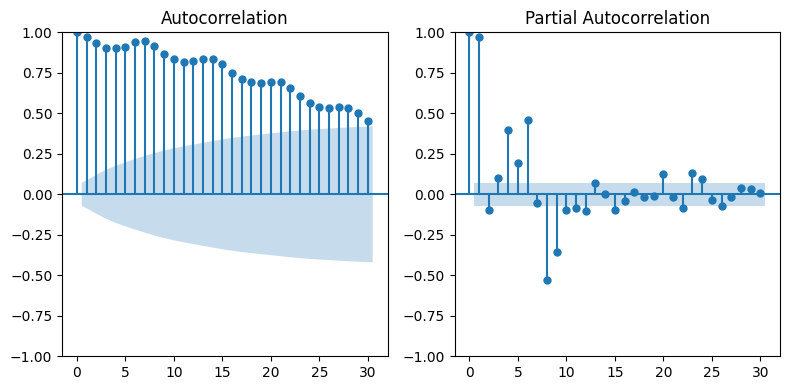

----------------Gird Search ARIMA------------------
Best Model Summary:
                               SARIMAX Results                                
Dep. Variable:          log_new_cases   No. Observations:                  774
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -478.260
Date:                Sun, 08 Dec 2024   AIC                            964.519
Time:                        19:32:26   BIC                            983.115
Sample:                             0   HQIC                           971.675
                                - 774                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6897      0.014     50.293      0.000       0.663       0.717
ma.L1         -1.9096      0.018   -104.758      0.000     

In [67]:
for region in regionss:
    print(f"----------------Region: {region}------------------")
    data = pd.read_csv(r"data\owid-covid-data.csv")
    data = data[data["iso_code"] == region]
    data = data[["date", "new_cases"]]
    pipeline(data, "new_cases", 30)